# 01_calculo_precios.ipynb

## Cálculo automatizado de precios de piezas plásticas inyectadas
Este notebook implementa el sistema de cálculo automatizado de presupuestos de piezas plásticas inyectadas a partir de datos técnicos y económicos.


In [1]:
# Importar las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 1. Carga de datos
Cargamos los datos de los ficheros .csv (características técnicas) y .xlsx (datos económicos).
Una vez cargados, mostramos la vista previa de cada uno de ellos.

In [2]:
# Cargar datos técnicos (.csv) y económicos (.xlsx)
df_piezas = pd.read_csv("datos_piezas.csv", sep=';')
df_costes = pd.read_excel("tarifas_costes.xlsx", sheet_name=None)
df_materiales = df_costes["Materiales"]
df_maquinas = df_costes["Maquinas"]
df_costes_adicionales = df_costes["Costes Adicionales"]

In [3]:
# Mostrar las primeras filas del fichero técnico
print("Vista previa del fichero de piezas:")
df_piezas.head(10)

Vista previa del fichero de piezas:


,referencia,descripcion,material,peso_(kg),tiempo_ciclo_(s),numero_cavidades,tonelaje_maquina
0,REF001,Pieza A,PP UV,0.25,40,2,200
1,REF002,Pieza B,ASA,0.50,45,2,350
2,REF003,Pieza C,PC,0.75,50,1,500
3,REF004,Pieza D,PP-TD20,0.15,35,4,150
4,REF005,Pieza E,ABS,0.90,55,1,650
5,REF006,Pieza F,PMMA,0.30,38,2,270
6,REF007,Pieza G,PC-ABS,1.20,60,1,1000
7,REF008,Pieza H,PP-GF30,0.40,42,2,420
8,REF009,Pieza I,POM,0.60,48,2,500
9,REF010,Pieza J,PP-TD10 UV,0.10,32,4,100


In [4]:
# Mostrar vista previa de la hoja "Materiales"
print("Vista previa de materiales:")
df_materiales.head()

Vista previa de materiales:


,material,precio_material,scrap
0,ASA,3.12,0.035
1,PC,2.47,0.050
2,ABS,1.89,0.080
3,PC-ABS,2.63,0.065
4,PE,1.04,0.025


In [5]:
# Mostrar vista previa de la hoja "Maquinas"
print("Vista previa de maquinas:")
df_maquinas.head()

Vista previa de maquinas:


,tonelaje_maquina,tarifa_maquina
0,100,25.0
1,150,28.5
2,200,31.0
3,230,35.0
4,270,41.0


In [6]:
# Mostrar vista previa de la hoja "Costes Adicionales"
print("Vista previa de costes adicionales:")
df_costes_adicionales.head()

Vista previa de costes adicionales:


,tarifa_manobra,margen_comercial
0,35,0.2


### 2. Validación de datos
Se comprueba que las columnas necesarias están presentes y bien tipadas, y que los materiales y máquinas son válidos.


In [7]:
# Función de validación
def validar_datos(df_piezas, df_materiales, df_maquinas, df_costes_adicionales):
    columnas_numericas = ['peso_(kg)', 'tiempo_ciclo_(s)', 'numero_cavidades', 'tonelaje_maquina']
    for col in columnas_numericas:
        if col not in df_piezas.columns:
            raise ValueError(f"Falta la columna '{col}' en el fichero de piezas.")
        if not pd.api.types.is_numeric_dtype(df_piezas[col]):
            raise ValueError(f"La columna '{col}' debe contener valores numéricos.")
        if df_piezas[col].isnull().any() or (df_piezas[col] <= 0).any():
            raise ValueError(f"Error en '{col}': contiene valores nulos o no positivos.")

    materiales_piezas = set(df_piezas['material'].unique())
    materiales_validos = set(df_materiales['material'].unique())
    materiales_no_encontrados = materiales_piezas - materiales_validos
    if materiales_no_encontrados:
        raise ValueError(f"Materiales no reconocidos: {materiales_no_encontrados}")

    maquinas_usadas = set(df_piezas['tonelaje_maquina'].unique())
    maquinas_validas = set(df_maquinas['tonelaje_maquina'].unique())
    maquinas_no_encontradas = maquinas_usadas - maquinas_validas
    if maquinas_no_encontradas:
        raise ValueError(f"Máquinas no reconocidas en tarifas: {maquinas_no_encontradas}")

    if not df_materiales['scrap'].between(0, 1).all():
        raise ValueError("Valores de scrap fuera del rango (0, 1)")

    if df_costes_adicionales.isnull().any().any():
        raise ValueError("Faltan valores en la hoja de Costes Adicionales")

    print("La validación de datos se ha realizado correctamente. Los datos son correctos.")

# Ejecutar validación
validar_datos(df_piezas, df_materiales, df_maquinas, df_costes_adicionales)

La validación de datos se ha realizado correctamente. Los datos son correctos.


### 3. Análisis Exploratorio de Datos (EDA)

#### 3.1. Estadística descriptiva

In [8]:
df_piezas.describe()

,peso_(kg),tiempo_ciclo_(s),numero_cavidades,tonelaje_maquina
count,110.000000,110.000000,110.000000,110.000000
mean,3.254273,79.581818,1.500000,1845.636364
std,2.630529,28.296718,0.763262,1300.671335
min,0.100000,32.000000,1.000000,100.000000
25%,0.750000,52.000000,1.000000,650.000000
50%,3.000000,85.000000,1.000000,1800.000000
75%,5.425000,100.000000,2.000000,2700.000000
max,9.000000,140.000000,4.000000,4000.000000


#### 3.2. Comprobación de valores nulos y duplicados

In [9]:
print("VAlores nulos por variable:\n", df_piezas.isnull().sum())
print("\nCantidad de duplicados:", df_piezas.duplicated().sum())

VAlores nulos por variable:
 referencia          0
descripcion         0
material            0
peso_(kg)           0
tiempo_ciclo_(s)    0
numero_cavidades    0
tonelaje_maquina    0
dtype: int64

Cantidad de duplicados: 0


#### 3.3. Frecuencia de materiales

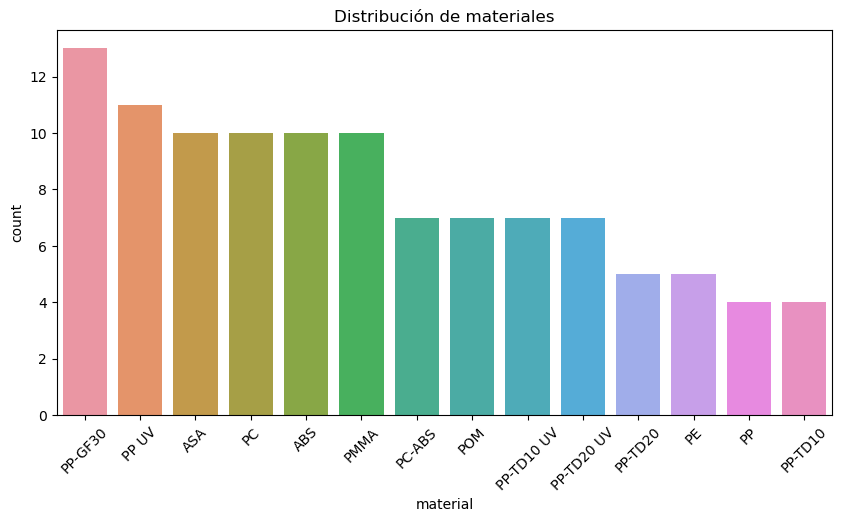

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_piezas, x="material", order=df_piezas["material"].value_counts().index)
plt.title("Distribución de materiales")
plt.xticks(rotation=45)
plt.show()


#### 3.4. Distribución de variables numéricas

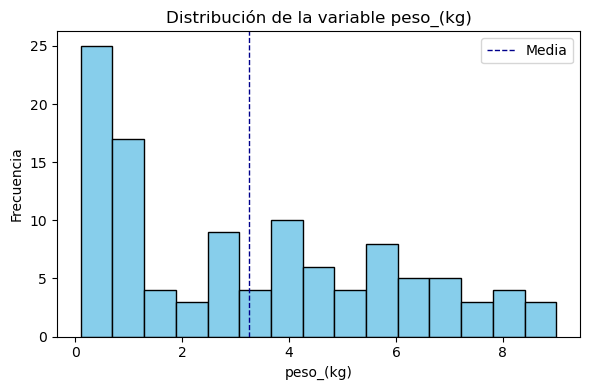

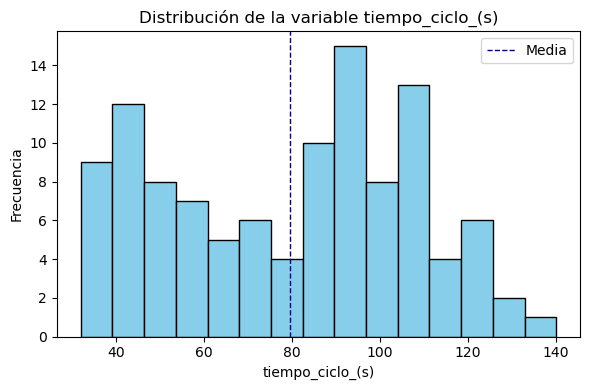

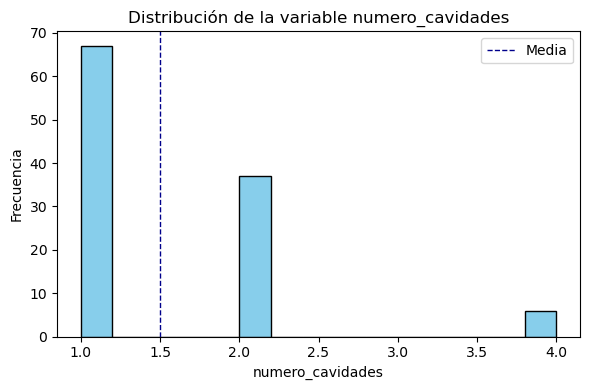

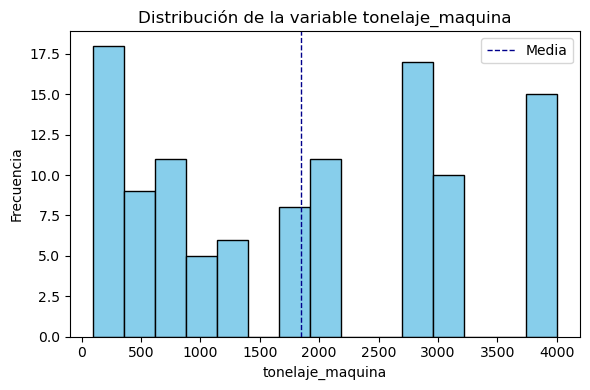

In [11]:
numerical_cols = ["peso_(kg)", "tiempo_ciclo_(s)", "numero_cavidades", "tonelaje_maquina"]

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    df_piezas[col].hist(bins=15, color='skyblue', edgecolor='black')
    plt.title(f"Distribución de la variable {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(False)
    plt.tight_layout()
    plt.axvline(df_piezas[col].mean(), color='darkblue', linestyle='dashed', linewidth=1, label='Media')
    plt.legend()
    plt.show()


#### 3.5. Valores atípicos mediante diagramas de caja (Boxplots)

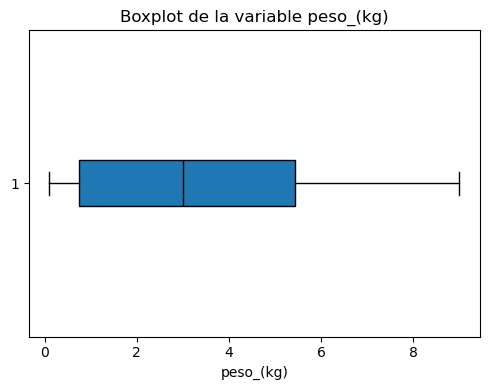

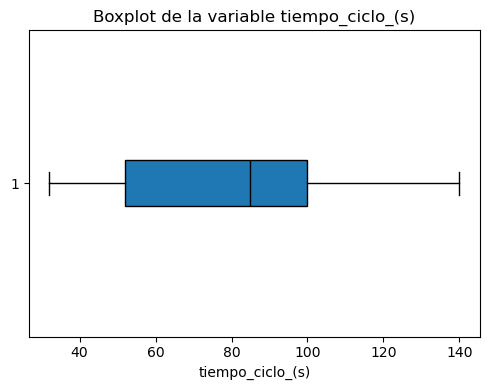

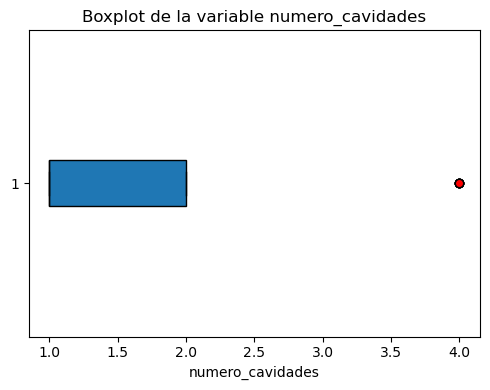

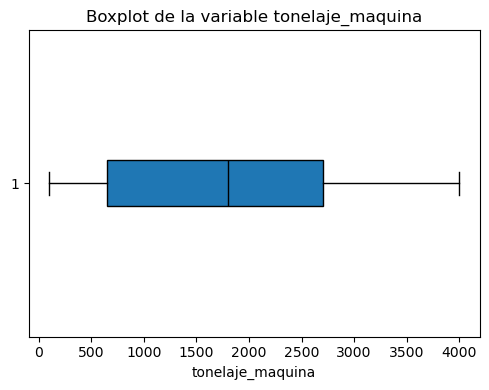

In [12]:
numerical_cols = ["peso_(kg)", "tiempo_ciclo_(s)", "numero_cavidades", "tonelaje_maquina"]

for col in numerical_cols:
    plt.figure(figsize=(5, 4))
    plt.boxplot(df_piezas[col], vert=False, patch_artist=True,
                boxprops=dict(color='black'),
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none'))

    plt.title(f"Boxplot de la variable {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()



#### 3.6. Correlación entre variables numéricas

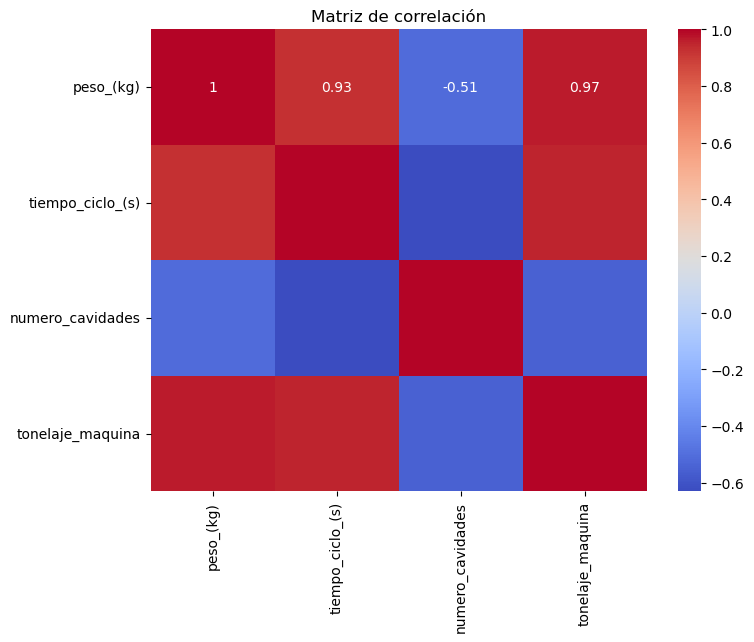

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_piezas[numerical_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

### 4. Asignación de precios y parámetros económicos


In [14]:
# Asignar precio y parámetros
materiales_precio_scrap = dict(zip(df_materiales['material'], zip(df_materiales['precio_material'], df_materiales['scrap'])))
maquinas_tarifas = dict(zip(df_maquinas['tonelaje_maquina'], df_maquinas['tarifa_maquina']))
tarifa_manobra = df_costes_adicionales['tarifa_manobra'].iloc[0]
margen_comercial = df_costes_adicionales['margen_comercial'].iloc[0]

### 5. Cálculo del coste total y del precio final


In [15]:
df_piezas['precio_material'] = df_piezas['material'].map(lambda x: materiales_precio_scrap[x][0])
df_piezas['scrap'] = df_piezas['material'].map(lambda x: materiales_precio_scrap[x][1])
df_piezas['tarifa_maquina'] = df_piezas['tonelaje_maquina'].map(maquinas_tarifas)

df_piezas['coste_material'] = df_piezas['peso_(kg)'] * df_piezas['precio_material']
df_piezas['coste_material_con_scrap'] = df_piezas['coste_material'] * (1 / (1 - df_piezas['scrap']))

df_piezas['coste_maquina'] = df_piezas['tarifa_maquina'] * (df_piezas['tiempo_ciclo_(s)'] / 3600) / df_piezas['numero_cavidades']
df_piezas['coste_manobra'] = tarifa_manobra * (df_piezas['tiempo_ciclo_(s)'] / 3600)

df_piezas['coste_total'] = df_piezas['coste_material_con_scrap'] + df_piezas['coste_maquina'] + df_piezas['coste_manobra']
df_piezas['precio_final'] = df_piezas['coste_total'] * (1 + margen_comercial)

df_piezas['precio_final'] = df_piezas['precio_final'].round(4)


### 6. Exportación de resultados


In [16]:
# Exportar .csv con resultados
columnas_salida = df_piezas.columns[:7].tolist() + ['precio_final']
df_piezas[columnas_salida].to_csv("piezas_con_precios.csv", sep=';', index=False)
print("El archivo 'piezas_con_precios.csv' se ha generado correctamente.")


El archivo 'piezas_con_precios.csv' se ha generado correctamente.


In [17]:
# Mostrar vista previa de los resultados
df_precios = pd.read_csv("piezas_con_precios.csv", sep=';')
df_precios.head(10)

,referencia,descripcion,material,peso_(kg),tiempo_ciclo_(s),numero_cavidades,tonelaje_maquina,precio_final
0,REF001,Pieza A,PP UV,0.25,40,2,200,1.1465
1,REF002,Pieza B,ASA,0.50,45,2,350,2.9074
2,REF003,Pieza C,PC,0.75,50,1,500,4.1983
3,REF004,Pieza D,PP-TD20,0.15,35,4,150,0.7708
4,REF005,Pieza E,ABS,0.90,55,1,650,4.4737
5,REF006,Pieza F,PMMA,0.30,38,2,270,1.8287
6,REF007,Pieza G,PC-ABS,1.20,60,1,1000,6.8945
7,REF008,Pieza H,PP-GF30,0.40,42,2,420,2.3159
8,REF009,Pieza I,POM,0.60,48,2,500,3.5333
9,REF010,Pieza J,PP-TD10 UV,0.10,32,4,100,0.6612
